In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from tqdm import trange
from utility import *
from dataset import *

In [2]:
# parameters of input data
num_samples = 30 # number of samples
data_dim = 50 # data dimension
num_classes = 3 # number of classes

# set the dimensions and number of layers
hidden_dim = 50
num_layers =  5 # number of layers before linear classifier

# parameters for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eps = 0.3 # scaling of initialization
lamb = 0 # weight decay parameter
dataset_type = "orthogonal" # Choose from [gaussian, uniform, mnist_partial, orthogonal]
init_method = "orthogonal" # model weight initialization method, choose from [default, identity, gaussian, orthogonal]

In [3]:
# data loader
if dataset_type == "gaussian":
    train_set, train_loader = gaussian_dataset(num_samples, data_dim, num_classes, bs=num_samples)
elif dataset_type == "uniform":
    train_set, train_loader = uniform_dataset(num_samples, data_dim, num_classes, bs=num_samples)
elif dataset_type == "mnist_partial":
    train_set, train_loader = mnist_4_class(num_samples, bs=500)
    test_set, test_loader = mnist_4_class(num_samples, bs=500, train=False)
    # change data_dim and hidden_dim to be compatible with MNIST
    data_dim = 784
    # hidden_dim = 784
    # print("Change data_dim and hidden_dim to 784 for compatible with MNIST")
    print("Change data_dim to 784 for compatible with MNIST")
elif dataset_type == "orthogonal":
    train_set, train_loader = orthogonal_dataset(num_samples, data_dim, num_classes, bs=num_samples)
    # data_dim = num_samples
    # hidden_dim = num_samples
    # eps = np.sqrt(2/hidden_dim)
    # print("data_dim is larger than num_samples for orthogonal dataset")
else:
    raise ValueError("Dataset Undefined!")

In [4]:
# Check for assumption 1 in the paper
for i, (data, label) in enumerate(train_loader):
    data, label = data.to(device), label.to(device)
    
norms = torch.linalg.norm(data, dim=1) ** 2
crosses = data @ data.T
print(torch.max(torch.abs(norms-1)) / num_samples)
print(torch.max(torch.abs(crosses - torch.diag(torch.diag(crosses)))) / num_samples)

tensor(0.0047)
tensor(0.0033)


In [5]:
# neural network
class Network(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, non_linear=False, bias=False, init_method="default"):
        super(Network, self).__init__()        
        # input layer of size data dim * hidden dim
        layers = [nn.Sequential(nn.Linear(data_dim, hidden_dim, bias=bias))]
        # hidden layers
        for i in range(1,num_layers):
            if non_linear:
                # ReLU activations
                if i == 1:
                    # layers = [nn.Sequential(nn.Linear(data_dim, hidden_dim, bias=bias), nn.ReLU())] 
                    layers = [nn.Sequential(nn.Linear(data_dim, hidden_dim, bias=bias), nn.BatchNorm1d(hidden_dim), nn.ReLU())] 
                # layers.append(nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias=bias), nn.ReLU()))
                layers.append(nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias=bias), nn.BatchNorm1d(hidden_dim), nn.ReLU()))
            else:
                 layers.append(nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias=bias)))   
        self.layers = nn.ModuleList(layers)
        self.non_linear = non_linear
        # final classifier
        self.fc = nn.Linear(hidden_dim, output_dim, bias=bias)      
        self.init_method = init_method
        self.init_weight(input_dim, hidden_dim, output_dim)
    
    def init_weight(self, input_dim, hidden_dim, output_dim):
        print(f"initialize weights using {self.init_method}!")
        if self.init_method == 'default':
            H, W = self.fc.weight.data.shape 
        elif self.init_method == 'identity':
            for i in range(num_layers):
                self.layers[i][0].weight.data = torch.eye(hidden_dim)*eps
            H, W = self.fc.weight.data.shape
            self.fc.weight.data = torch.eye(hidden_dim)[:H,:W] * eps
        elif self.init_method == "gaussian":
            for i in range(num_layers):
                nn.init.kaiming_normal_(self.layers[i][0].weight)
            nn.init.kaiming_normal_(self.fc.weight)
        elif self.init_method == "orthogonal":
            for i in range(num_layers):
                if i == 0:
                    weight = torch.randn(hidden_dim, input_dim)
                    weight = torch.linalg.svd(weight, full_matrices=False)[0]
                    # weight = torch.cat([weight, torch.zeros(hidden_dim-data_dim, data_dim)],dim=0)
                    self.layers[i][0].weight.data = weight * eps # weight[:,:data_dim] * eps
                else:
                    weight = torch.randn(hidden_dim, hidden_dim)
                    weight = torch.linalg.svd(weight)[0]
                    self.layers[i][0].weight.data = weight * eps
            fc_weight = torch.from_numpy(ortho_group.rvs(output_dim)).float()
            fc_weight = torch.cat([fc_weight, torch.zeros(output_dim, hidden_dim-output_dim)], 1)
            self.fc.weight.data = fc_weight * eps
        else:
            raise ValueError("Init Method un-defined!")            
    
    def forward(self, x):
        # store each layer's output
        out_list = []
        for layer in self.layers:
            # print(x.shape)
            x = layer(x)
            out_list.append(x.clone().detach())
        
        out = self.fc(x)
        return out, out_list

In [6]:
# MSE loss
def loss_fn_MSE(pred, target, model, lamb = 0.01):
    N,C = target.shape
    loss = torch.sum((100 * pred - target) ** 2) / N
    
    regu = 0
    if lamb != 0:
        for name, para in model.named_parameters():
            regu += torch.linalg.norm(para) ** 2 * lamb / 2
    return loss, loss + regu

# check balancedness in the training
def check_balance(model):
    """
    calculate norm(W_iW_i^T - W_{i+1}^T W_{i+1}, 'fro')
    """
    all_weights = []
    for name, para in model.named_parameters():
        # if "layers" in name and "weight" in name:
        if "weight" in name and len(para.shape) == 2:
            #print(name, para.shape)
            all_weights.append(para.data.cpu())
    
    norm_diffs = []
    for i in range(len(all_weights)-1):
        W_cur, W_next = all_weights[i], all_weights[i+1]
        diff = W_cur @ W_cur.T - W_next.T @ W_next
        norm_diffs.append(torch.linalg.norm(diff).item())
  
    return norm_diffs

def dict_to_mat(d1):
    """
    transfer the mu_c dictionary to a matrix
    """
    all_mat = []
    for l in d1:
        mat = []
        d1_l = d1[l]
        for key in d1_l:
            mat.append(d1_l[key])
        mat = np.vstack(mat)
        
        all_mat.append(mat)
    return all_mat
        
def max_angle_metric(muc_mat):
    """
    max |<u_k, u_l>|，u_k是k-th class的mean
    k \neq l
    """
    metric_list = []
    for i in range(len(muc_mat)):
        cur_muc = muc_mat[i]
        muc_norm = cur_muc / np.linalg.norm(cur_muc, axis=1)[:,None]
        cosine = muc_norm @ muc_norm.T
        cosine_need = np.tril(cosine, k=-1)
        cosine_need = cosine_need[cosine_need!=0]
        metric_list.append(np.max(cosine_need))
    return metric_list

In [7]:
# Create an instance of the linear-nonlinear network
model = Network(input_dim=data_dim, hidden_dim=hidden_dim, output_dim=num_classes, num_layers=num_layers,
                non_linear=False, init_method=init_method).to(device)

initialize weights using orthogonal!


In [8]:
print(model)

Network(
  (layers): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=50, out_features=50, bias=False)
    )
  )
  (fc): Linear(in_features=50, out_features=3, bias=False)
)


In [9]:
# training NNs via SGD
eta = 0.1
epochs = 5000 # number of epochs to train
optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = 0, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=epochs, eta_min=eta/10) #/1000

loss_list = []
balance_list = []

with trange(epochs, desc = "Start training") as pbar:
    for epoch in pbar:
        pbar.set_description(f"Epoch {epoch}")
        loss_cur_epoch = 0
        for i, (data, label) in enumerate(train_loader):
            data, label = data.to(device), label.to(device)
            balance_list.append(check_balance(model))
            pred, _ = model(data)
            true_loss, loss = loss_fn_MSE(pred, label, model, lamb=lamb)
            loss_cur_epoch += true_loss.item()    
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if epoch % 10 == 0:
            loss_cur_epoch /= len(train_set)
            grad_norm_after_epoch = get_gradient_norm(model).item()
            loss_list.append(loss_cur_epoch)
            pbar.set_postfix(Epoch = epoch, loss = loss_cur_epoch, grad_norm = grad_norm_after_epoch)
            if loss_cur_epoch < 1e-11 :
                print(loss)
                break
        
        if epoch % 1000 == 0:
            print(loss_cur_epoch)

Epoch 46:   0%|          | 24/5000 [00:00<00:42, 116.95it/s, Epoch=40, grad_norm=0.00348, loss=8.88e-8]

0.03338406483332316


Epoch 60:   1%|          | 60/5000 [00:00<00:33, 147.78it/s, Epoch=60, grad_norm=2.37e-5, loss=4.37e-12] 

tensor(1.3109e-10, grad_fn=<AddBackward0>)


In [10]:
# Get Compression
ssw_fro_list, ssb_fro_list, nc1_list, nc1_tilde_list = calculate_nc1(model, train_loader, num_layers, device)
np.array(nc1_tilde_list)

array([11.9993305 ,  3.4821217 ,  0.9843595 ,  0.2763253 ,  0.07745831,
        0.02171478], dtype=float32)

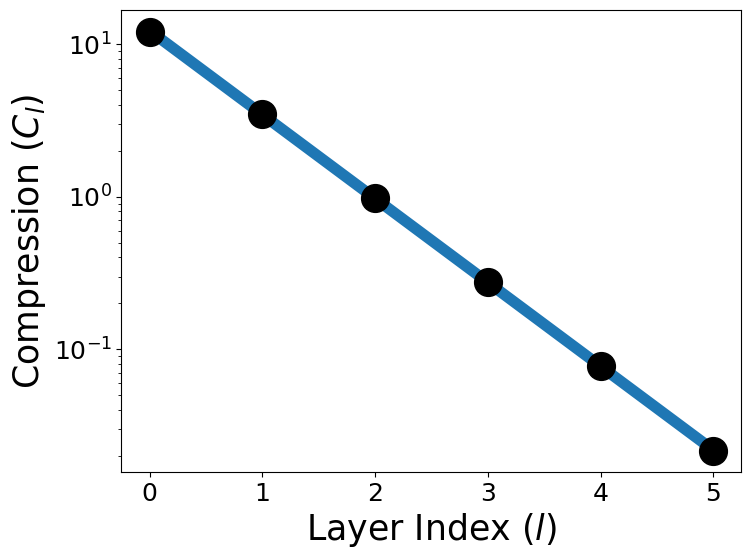

In [11]:
from numpy.polynomial import polynomial as P

# plot the variant of the NC1 metric w.r.t layer
fig = plt.figure(figsize = (8,6))
coef = P.polyfit(np.arange(len(nc1_tilde_list)), np.log10(nc1_tilde_list), deg=1)
x_axis = np.arange(0, num_layers+1)
plt.semilogy(x_axis, 10**(coef[0] + coef[1]*np.arange(0, num_layers+1)), c='tab:blue', linewidth=8)
plt.semilogy(x_axis, nc1_tilde_list, 'o', c='black', markersize=20)
plt.xlabel(r'Layer Index ($l$)', fontsize=25)
plt.ylabel(r'Compression ($C_l$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(np.arange(0, num_layers+1))
plt.show()
# fig.savefig(f"figs/{num_layers+1}_layer_nonlinear_intro_within.pdf", bbox_inches='tight')

In [12]:
# Get Discrimination
mu_c = compute_info(model, train_loader, num_layers, device)[1]
mu_c_mat = dict_to_mat(mu_c)
res = max_angle_metric(mu_c_mat)
print(res)
1-np.array(res)

[0.031943027, 0.02837523, 0.023906346, 0.019087153, 0.014142118]


array([0.968057  , 0.9716248 , 0.97609365, 0.98091286, 0.9858579 ],
      dtype=float32)

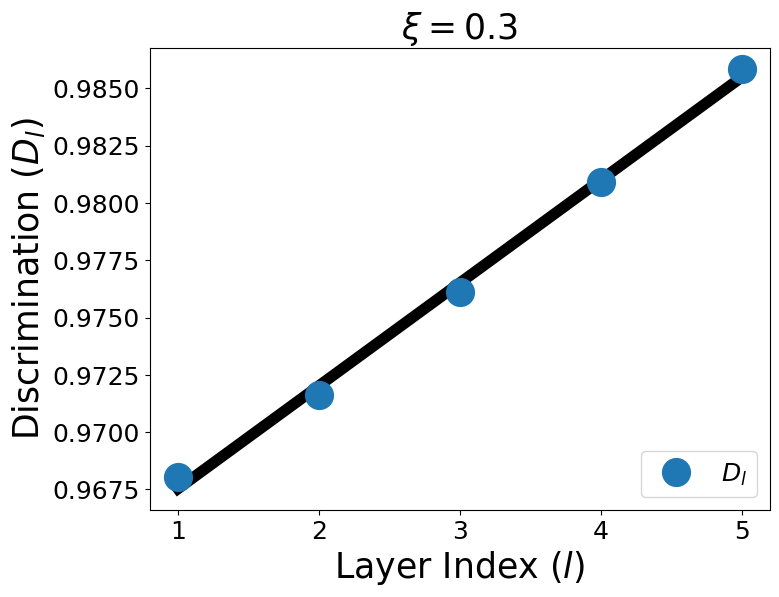

In [13]:
D_l = 1-np.array(res)
coef = P.polyfit(np.arange(len(D_l)), D_l, deg=1)
fig = plt.figure(figsize=(8,6))

x_axis = np.arange(0, num_layers)
plt.plot(x_axis+1, coef[0] + coef[1]*np.arange(0, num_layers), c='black', linewidth=8)
plt.plot(x_axis+1, D_l, 'o', c='tab:blue', markersize=20, label=r"$D_l$")
# plt.plot(x_axis+1, dl_lower, c='tab:green', linewidth=8, linestyle="-.", label=r"Lower Bound")
plt.xlabel(r'Layer Index ($l$)', fontsize=25)
plt.ylabel(r'Discrimination ($D_l$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(np.arange(1, num_layers+1))
plt.title(fr"$\xi = {eps}$", fontsize=25)
# plt.ylim(0.9,1.0)
plt.legend(fontsize=18, loc="lower right")
plt.show()
# fig.savefig(f"figs/{num_layers+1}_layer_eps{eps}_between.pdf", bbox_inches='tight')